# Index
## Problem Statement
## Wrangle Azdias dataset
## Some Transformations on Azdias
## Clustering Azdias
## Same Wrangling on Customers datasets
## Same Transformations on Customers datasets
## Clusters of Customers in Azdias
## Supervised Learning

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import autogluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import sklearn
import pca
import pickle
# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
def get_attribute_name(original_df, index):
    up_index = index
    while type(original_df.iloc[up_index, 0]) == float: #equals NaN
        up_index = up_index - 1
    return up_index, original_df.iloc[up_index, 0] #type == str means not equal NaN

In [3]:
def replace_unknowns(df):
    original_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
    unknowns = original_df.copy()
    unknowns = unknowns.iloc[:,1:] #remove first column
    unknowns.set_axis(unknowns.iloc[0,:], axis='columns', inplace=True)#inplace worked on another environment #rename column names
    unknowns = unknowns.iloc[1:,:] #remove first row
    original_df = unknowns.copy() #after cleaning
    unknowns = unknowns[['Attribute', 'Value']].where(unknowns['Meaning'].str.contains('unknown')).dropna(how='all') #drop if all row values are all Nones
    indices, attribute_names = list(map(lambda index: get_attribute_name(original_df, index), unknowns[unknowns['Attribute'].isnull()].index))
    for index, attribute_name in indices, attribute_names:
        unknowns.loc[index, 'Attribute'] = attribute_name
    unknowns_dict = dict(zip(unknowns['Attribute'], unknowns['Value']))
    for column_name, values in unknowns_dict.items():
        if column_name in df.columns:
            try:
                values_list = values.split(',')
            except:
                values_list = [int(values)]
            df[column_name] = df[column_name].replace([int(value) for value in values_list], float('NaN'))
        else:
            print(f"Column '{column_name}' not found in DataFrame.")
    return df
    

In [4]:
#vleaning function for azdias and customers
def clean_unsupervised(df):
    

    columns_to_drop = ['EINGEFUEGT_AM', 'CAMEO_INTL_2015', 'ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP']
    ################
    #actual change in the df

    #replace unknowns by NaNs
    replace_unknowns(df)

    #drop some columns
    df.drop(columns= columns_to_drop, inplace=True)

    #change dtypes
    
    df = df.convert_dtypes(convert_string=False) #converts to the most suitable type

    #change 'CAMEO_DEU_2015' to numerical
    L1 = df['CAMEO_DEU_2015'].value_counts().index
    L1.sort_values()
    print(L1)
    print(len(L1))#45

    L2 = list(range(1,45))
    L2.extend([np.nan])

    print(L2)
    print(len(L2))#45

    df['CAMEO_DEU_2015'].replace(L1, L2, inplace=True)
    df['CAMEO_DEU_2015'].astype('Int64')

    #change 'OST_WEST_KZ' to numerical
    df['OST_WEST_KZ'].replace(['W', 'O', 'NaN'], [1, 2, np.nan], inplace=True)
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].astype('Int64')

    #change 'D19_LETZTER_KAUF_BRANCHE' into numerical
    L1 = ['D19_UNBEKANNT', 'D19_VERSICHERUNGEN', 'D19_SONSTIGE',
       'D19_VOLLSORTIMENT', 'D19_SCHUHE', 'D19_BUCH_CD', 'D19_VERSAND_REST',
       'D19_DROGERIEARTIKEL', 'D19_BANKEN_DIREKT', 'D19_BEKLEIDUNG_REST',
       'D19_HAUS_DEKO', 'D19_TELKO_MOBILE', 'D19_ENERGIE', 'D19_TELKO_REST',
       'D19_BANKEN_GROSS', 'D19_BEKLEIDUNG_GEH', 'D19_TECHNIK',
       'D19_KINDERARTIKEL', 'D19_FREIZEIT', 'D19_LEBENSMITTEL',
       'D19_BANKEN_REST', 'D19_RATGEBER', 'D19_NAHRUNGSERGAENZUNG',
       'D19_DIGIT_SERV', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_TIERARTIKEL',
       'D19_HANDWERK', 'D19_WEIN_FEINKOST', 'D19_GARTEN', 'D19_BANKEN_LOKAL',
       'D19_BIO_OEKO', 'D19_BILDUNG', 'D19_KOSMETIK', 'D19_LOTTO']
    len(L1)
    L2 = list(range(1, 36))
    len(L2)
    df['D19_LETZTER_KAUF_BRANCHE'].replace(L1, L2, inplace=True)
    df['D19_LETZTER_KAUF_BRANCHE'] = df['D19_LETZTER_KAUF_BRANCHE'].astype('Int64')

    df['CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float')
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('Int64') #not int to allow NaNs
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].astype('Int64')

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

In [46]:
#cleaning function for mailout_train and mailout_test

def clean_supervised(df):
    #remove missing values
    df['CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
    df['CAMEO_INTL_2015'].replace('XX', np.nan, inplace=True)
    df.fillna(np.nan, inplace=True) #replace None by np.nan 
    df = replace_unknowns(df)
    imputer = SimpleImputer(strategy='most_frequent', copy=False)
    x = imputer.fit_transform(df)
    df = pd.DataFrame(x, columns = df.columns)

    #change dtypes
    df = df.set_index('LNR')
    
    df = df.convert_dtypes()

    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'])

    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float')
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('int32')#'Int64') #not int to allow NaNs
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('category')

    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('float')
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('Int64') #not int to allow NaNs
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('category')

    df[['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ']] = df[['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ']].astype('category')

    df[df.select_dtypes(include=['Int64']).columns.drop('KBA13_ANZAHL_PKW')] = df[df.select_dtypes(include=['Int64']).columns.drop('KBA13_ANZAHL_PKW')].astype(pd.CategoricalDtype(ordered=True))#'category', copy=False)

    df['KBA13_ANZAHL_PKW'] = df['KBA13_ANZAHL_PKW'].astype(int)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Download Data

Write these lines in the Udacity workspace
```python
import pandas as pd

azidas = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
azidas.to_csv('./Udacity_AZDIAS_052018.csv', sep=';', index=False)

customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
customers.to_csv('./Udacity_CUSTOMERS_052018.csv', sep=';', index=False)

mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.to_csv('./Udacity_MAILOUT_052018_TRAIN.csv', sep=';', index=False)

mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test.to_csv('./Udacity_MAILOUT_052018_TEST.csv', sep=';', index=False)

```
Then, open them and download them from the workspace to your computer manually: File --> Download

### Explore Data

In [6]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')

C:\Users\dell\AppData\Local\Temp\ipykernel_12048\2566523469.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')


In [7]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,15.0,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,825771,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,11.0,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,825772,-1,1.0,17.0,NaN,NaN,NaN,NaN,17.0,3.0,...,2.0,7.0,10.0,8.0,NaN,5.0,7.0,4,2,2
891219,825776,-1,9.0,0.0,17.0,NaN,NaN,NaN,20.0,7.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1


In [8]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


### Clean Data

In [9]:
#find columns in the dataset that are not in Dias Attributes
original_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx')

In [10]:
original_df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Attribute,Description,Value,Meaning
1,NaN,AGER_TYP,best-ager typology,-1,unknown
2,NaN,NaN,NaN,0,no classification possible
3,NaN,NaN,NaN,1,passive elderly
4,NaN,NaN,NaN,2,cultural elderly


In [11]:
attributes_in_file = original_df.iloc[1:, 1].copy()

In [12]:
attributes_in_file.head()

1    AGER_TYP
2         NaN
3         NaN
4         NaN
5         NaN
Name: Unnamed: 1, dtype: object

In [13]:
attributes_in_file.dropna(inplace=True)

In [14]:
attributes_in_file.head()

1                 AGER_TYP
6     ALTERSKATEGORIE_GROB
12                ALTER_HH
34               ANREDE_KZ
37     ANZ_HAUSHALTE_AKTIV
Name: Unnamed: 1, dtype: object

In [15]:
attributes_in_file.count()

314

In [16]:
#See how many columns will be left if we only kept columns that are in both the Dias Attributes file and the dataset
azdias[set(azdias.columns)&set(attributes_in_file)].count() #this worked correctly on another environment. I seems that some packages have different versions
#azdias[list(set(azdias.columns)&set(attributes_in_file))].count()

C:\Users\dell\AppData\Local\Temp\ipykernel_12048\2929450171.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  azdias[set(azdias.columns)&set(attributes_in_file)].count() #this worked correctly on another environment. I seems that some packages have different versions


ALTERSKATEGORIE_GROB       891221
KBA13_HALTER_65            785421
KBA13_SEG_SPORTWAGEN       785421
KBA13_BJ_2000              785421
KBA13_KRSHERST_BMW_BENZ    785421
                            ...  
BALLRAUM                   797481
KBA13_HALTER_30            785421
LP_FAMILIE_FEIN            886367
KBA13_MAZDA                785421
AGER_TYP                   891221
Length: 272, dtype: int64

272 columns are too much lower than 366, so I will not take the risk of removing all these columns (difference). I think that attributes in the file are the categorical columns only.

I knew the names of the columns in the file that are not in the azdias data set by trying this:    
azdias = azdias[attributes_in_file]        
I got:   
KeyError: "['D19_DIGIT_SERV_RZ', 'D19_TIERARTIKEL_RZ', 'WACHSTUMSGEBIET_NB', 'BIP_FLAG', 'D19_TELKO_MOBILE_RZ', 'D19_HAUS_DEKO_RZ', 'D19_BEKLEIDUNG_GEH_RZ', 'D19_VERSAND_REST_RZ', 'D19_BANKEN_REST_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BEKLEIDUNG_REST_RZ', 'HAUSHALTSSTRUKTUR', 'D19_BANKEN_GROSS_RZ', 'D19_HANDWERK_RZ', 'D19_VOLLSORTIMENT_RZ', 'D19_BUCH_RZ', 'CAMEO_DEUINTL_2015', 'D19_VERSICHERUNGEN_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_GARTEN_RZ', 'D19_SCHUHE_RZ', 'D19_TELKO_REST_RZ', 'KBA13_CCM_1400_2500', 'D19_LOTTO_RZ', 'D19_BILDUNG_RZ', 'D19_KK_KUNDENTYP', 'D19_WEIN_FEINKOST_RZ', 'D19_SONSTIGE_RZ', 'D19_BIO_OEKO_RZ', 'D19_REISEN_RZ', 'D19_TECHNIK_RZ', 'D19_ENERGIE_RZ', 'D19_BANKEN_DIREKT_RZ', 'SOHO_FLAG', 'D19_RATGEBER_RZ', 'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_SAMMELARTIKEL_RZ', 'D19_FREIZEIT_RZ', 'GEOSCORE_KLS7', 'D19_LEBENSMITTEL_RZ', 'D19_KOSMETIK_RZ'] not in index"

In [17]:
#convert unknowns into Nans only--> Data consistency: sum unknowns are NaNs, some are -1, some are 0 and some are 9. 
unknowns = original_df.copy()#pd.read_excel('DIAS Attributes - Values 2017.xlsx')

In [18]:
unknowns = unknowns.iloc[:,1:] #remove first column
unknowns.set_axis(unknowns.iloc[0,:], axis='columns', inplace=True)#inplace worked on another environment #rename column names
unknowns = unknowns.iloc[1:,:] #remove first row
original_df = unknowns.copy() #after cleaning
unknowns.head()

C:\Users\dell\AppData\Local\Temp\ipykernel_12048\2597164357.py:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  unknowns.set_axis(unknowns.iloc[0,:], axis='columns', inplace=True)#inplace worked on another environment #rename column names


,Attribute,Description,Value,Meaning
1,AGER_TYP,best-ager typology,-1,unknown
2,NaN,NaN,0,no classification possible
3,NaN,NaN,1,passive elderly
4,NaN,NaN,2,cultural elderly
5,NaN,NaN,3,experience-driven elderly


In [19]:
original_df.head()

,Attribute,Description,Value,Meaning
1,AGER_TYP,best-ager typology,-1,unknown
2,NaN,NaN,0,no classification possible
3,NaN,NaN,1,passive elderly
4,NaN,NaN,2,cultural elderly
5,NaN,NaN,3,experience-driven elderly


In [20]:
(unknowns['Meaning']=='unknown').sum()

232

In [21]:
(unknowns['Meaning'].str.contains('unknown')).sum()

233

I was about to miss one!!

In [22]:
unknowns = unknowns[['Attribute', 'Value']].where(unknowns['Meaning'].str.contains('unknown')).dropna(how='all') #drop if all row values are all Nones
#when I tried it without how='all' I got 231 rows only instead of 233
unknowns

,Attribute,Value
1,AGER_TYP,-1
6,ALTERSKATEGORIE_GROB,"-1, 0"
12,ALTER_HH,0
34,ANREDE_KZ,"-1, 0"
41,BALLRAUM,-1
...,...,...
2220,WOHNDAUER_2008,"-1, 0"
2230,WOHNLAGE,-1
2239,WACHSTUMSGEBIET_NB,"-1, 0"
2245,W_KEIT_KIND_HH,"-1, 0"


In [23]:
unknowns['Value'].dtype

dtype('O')

In [24]:
unknowns[unknowns['Attribute'].isnull()]

,Attribute,Value
822,NaN,"-1, 9"
2084,NaN,"-1, 9"


822 and 2084 are the two indeces that we need to get their attribute names

In [25]:
#print(original_df.iloc[817, 1])
#print(len(original_df.iloc[817, 1]))
#print(type(original_df.iloc[822, 1])==float)

x1, name1 = get_attribute_name(original_df, 822)
x2, name2 = get_attribute_name(original_df, 2084)
print(x1, name1, x2, name2)

822 KBA05_BAUMAX 2084 RETOURTYP_BK_S


This can be done also by ffill() but I believe that this function is faster as it iterates on fewer rows

In [26]:
#unknowns.iloc[822] 
#unknowns.iat[822]
#unknowns.at[822]
unknowns.loc[822, 'Attribute'] = name1
unknowns.loc[2084, 'Attribute'] = name2
unknowns.loc[2084]
unknowns.loc[822]

0
Attribute    KBA05_BAUMAX
Value               -1, 9
Name: 822, dtype: object

In [27]:
unknowns_dict = dict(zip(unknowns['Attribute'], unknowns['Value']))
unknowns_dict

{'AGER_TYP': -1,
 'ALTERSKATEGORIE_GROB': '-1, 0',
 'ALTER_HH': 0,
 'ANREDE_KZ': '-1, 0',
 'BALLRAUM': -1,
 'BIP_FLAG': -1,
 'CAMEO_DEUG_2015': -1,
 'CAMEO_DEUINTL_2015': -1,
 'CJT_GESAMTTYP': 0,
 'D19_KK_KUNDENTYP': -1,
 'EWDICHTE': -1,
 'FINANZTYP': -1,
 'FINANZ_ANLEGER': -1,
 'FINANZ_HAUSBAUER': -1,
 'FINANZ_MINIMALIST': -1,
 'FINANZ_SPARER': -1,
 'FINANZ_UNAUFFAELLIGER': -1,
 'FINANZ_VORSORGER': -1,
 'GEBAEUDETYP': '-1, 0',
 'GEOSCORE_KLS7': '-1, 0',
 'HAUSHALTSSTRUKTUR': '-1, 0',
 'HEALTH_TYP': -1,
 'HH_EINKOMMEN_SCORE': '-1, 0',
 'INNENSTADT': -1,
 'KBA05_ALTER1': '-1, 9',
 'KBA05_ALTER2': '-1, 9',
 'KBA05_ALTER3': '-1, 9',
 'KBA05_ALTER4': '-1, 9',
 'KBA05_ANHANG': '-1, 9',
 'KBA05_ANTG1': -1,
 'KBA05_ANTG2': -1,
 'KBA05_ANTG3': -1,
 'KBA05_ANTG4': -1,
 'KBA05_BAUMAX': '-1, 0',
 'KBA05_CCM1': '-1, 9',
 'KBA05_CCM2': '-1, 9',
 'KBA05_CCM3': '-1, 9',
 'KBA05_CCM4': '-1, 9',
 'KBA05_DIESEL': '-1, 9',
 'KBA05_FRAU': '-1, 9',
 'KBA05_GBZ': '-1, 0',
 'KBA05_HERST1': '-1, 9',
 'KBA05_H

In [28]:
#This to compare between num of nulls before and after replacing unknowns with NaNs
azdias.isnull().sum().sort_values(ascending=False)

ALTER_KIND4                  890016
ALTER_KIND3                  885051
ALTER_KIND2                  861722
ALTER_KIND1                  810163
EXTSEL992                    654153
                              ...  
D19_VERSAND_ANZ_24                0
D19_VERSAND_DATUM                 0
D19_VERSAND_OFFLINE_DATUM         0
D19_VERSAND_ONLINE_DATUM          0
ALTERSKATEGORIE_GROB              0
Length: 366, dtype: int64

In [29]:
for column_name, values in unknowns_dict.items():
    if column_name in azdias.columns:
        try:
            values_list = values.split(',')
        except:
            values_list = [int(values)]
        azdias[column_name] = azdias[column_name].replace([int(value) for value in values_list], float('NaN'))
    else:
        print(f"Column '{column_name}' not found in DataFrame.")

Column 'BIP_FLAG' not found in DataFrame.
Column 'CAMEO_DEUINTL_2015' not found in DataFrame.
Column 'D19_KK_KUNDENTYP' not found in DataFrame.
Column 'GEOSCORE_KLS7' not found in DataFrame.
Column 'HAUSHALTSSTRUKTUR' not found in DataFrame.
Column 'KBA13_CCM_1400_2500' not found in DataFrame.
Column 'SOHO_FLAG' not found in DataFrame.
Column 'WACHSTUMSGEBIET_NB' not found in DataFrame.


In [30]:
azdias.isnull().sum().sort_values(ascending=False)

ALTER_KIND4             890016
TITEL_KZ                889061
ALTER_KIND3             885051
ALTER_KIND2             861722
ALTER_KIND1             810163
                         ...  
D19_TELKO_ANZ_24             0
D19_TELKO_ANZ_12             0
D19_TECHNIK                  0
D19_SONSTIGE                 0
ALTERSKATEGORIE_GROB         0
Length: 366, dtype: int64

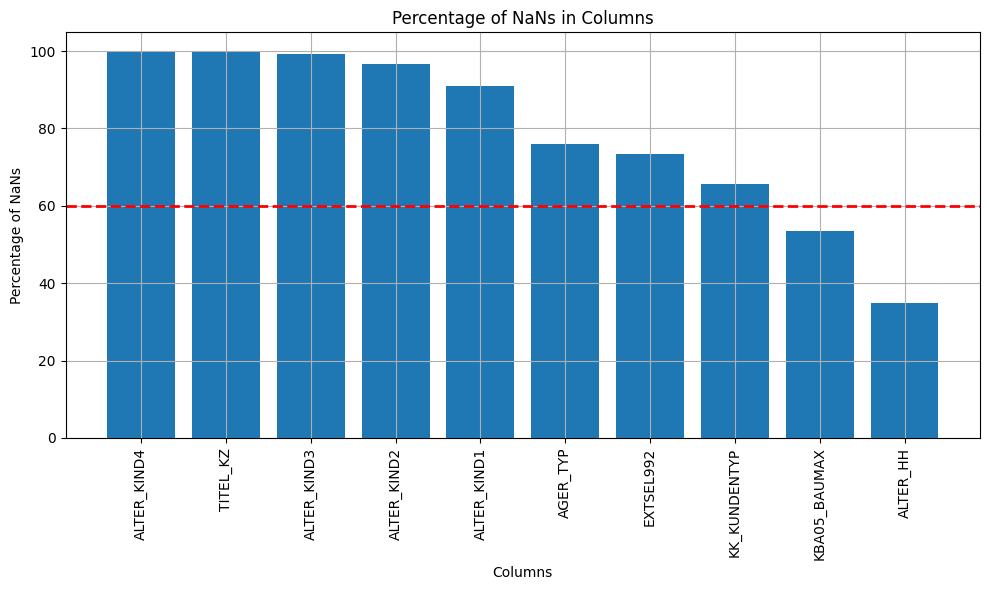

In [31]:
#Let's make it visual for the highest 10 columns that have NaNs
nan_percentages = (azdias.isnull().sum().sort_values(ascending=False)[:10])/azdias.shape[0]*100
plt.figure(figsize=(10, 6))
plt.bar(nan_percentages.index, nan_percentages.values)
plt.axhline(y=60, color='red', linestyle='--', linewidth=2) #the red line indicating 60%
plt.xlabel('Columns')
plt.ylabel('Percentage of NaNs')
plt.title('Percentage of NaNs in Columns')
plt.xticks(rotation=90) #names of columns to be vertical
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# I decided to drop the most 8 column (above 60% NaNs)
print((azdias.isnull().sum().sort_values(ascending=False)[:8]).index)
azdias.drop(columns=(azdias.isnull().sum().sort_values(ascending=False)[:8]).index, inplace=True)

Index(['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1',
       'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP'],
      dtype='object')


In [33]:
azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,9.0,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


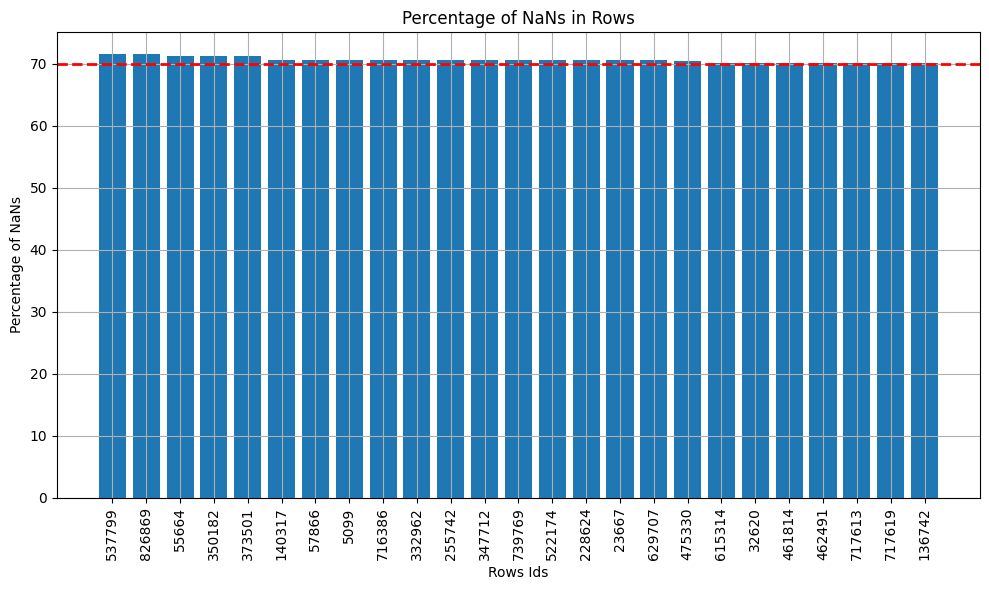

Int64Index([537799, 826869,  55664, 350182, 373501, 140317,  57866,   5099,
            716386, 332962, 255742, 347712, 739769, 522174, 228624,  23667,
            629707, 475330, 615314,  32620, 461814, 462491, 717613, 717619,
            136742],
           dtype='int64')


In [34]:
#Do the same for rows:
nan_percentages_rows = (azdias.isnull().sum(axis=1).sort_values(ascending=False)[:25])/azdias.shape[1]*100
plt.figure(figsize=(10, 6))
plt.bar(list(map(str,nan_percentages_rows.index)), nan_percentages_rows.values)
plt.axhline(y=70, color='red', linestyle='--', linewidth=2) #the red line indicating 70%
plt.xlabel('Rows Ids')
plt.ylabel('Percentage of NaNs')
plt.title('Percentage of NaNs in Rows')
plt.xticks(rotation=90) #names of rows to be vertical
plt.grid(True)
plt.tight_layout()
plt.show()
print(nan_percentages_rows.index)

In [35]:
#I decided to drop the 18 top rows that have more than 70% Nans
azdias.drop(index=(azdias.isnull().sum(axis=1).sort_values(ascending=False)[:18]).index, inplace=True)

In [36]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891203 entries, 0 to 891220
Columns: 358 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(265), int64(87), object(6)
memory usage: 2.4+ GB


In [37]:
azdias.dtypes.value_counts()

float64    265
int64       87
object       6
dtype: int64

In [38]:
#only 6 strings, others should be int
azdias = azdias.convert_dtypes(convert_string=False) #converts to the most suitable type
azdias.dtypes.value_counts()

Int64     352
object      6
dtype: int64

In [39]:
azdias[azdias.select_dtypes(include='object').columns]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
2,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7.0,41.0,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9.0,51.0,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4.0,24.0,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9.0,51.0,D19_UNBEKANNT,1992-02-12 00:00:00,W


In [40]:
L1 = azdias['CAMEO_DEU_2015'].value_counts().index
L1.sort_values()
print(L1)
print(len(L1))#45

L2 = list(range(1,45))
L2.extend([np.nan])

print(L2)
print(len(L2))#45

azdias['CAMEO_DEU_2015'].replace(L1, L2, inplace=True)

Index(['6B', '8A', '4C', '2D', '3C', '7A', '3D', '8B', '4A', '8C', '9D', '9B',
       '9C', '7B', '9A', '2C', '8D', '6E', '2B', '5D', '6C', '2A', '5A', '1D',
       '1A', '3A', '5B', '5C', '7C', '4B', '4D', '3B', '6A', '9E', '6D', '6F',
       '7D', '4E', '1E', '7E', '1C', '5F', '1B', '5E', 'XX'],
      dtype='object')
45
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, nan]
45


In [41]:
azdias['CAMEO_DEU_2015'].astype('Int64')

0         <NA>
1            2
2            3
3           22
4            1
          ... 
891216       6
891217      11
891218       3
891219      11
891220       1
Name: CAMEO_DEU_2015, Length: 891203, dtype: Int64

In [42]:
azdias['CAMEO_INTL_2015'].value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

Notice the inconsistency in data: 51&51.0 and 41&41.0

In [43]:
azdias['CAMEO_INTL_2015'] = azdias[azdias['CAMEO_INTL_2015']=='XX']['CAMEO_INTL_2015'].replace(np.nan, inplace=True)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype('float')
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype('Int64') #not int to allow NaNs

In [44]:
azdias['EINGEFUEGT_AM'] = pd.to_datetime(azdias['EINGEFUEGT_AM'])

In [45]:
azdias['EINGEFUEGT_AM']

0               NaT
1        1992-02-10
2        1992-02-12
3        1997-04-21
4        1992-02-12
            ...    
891216   1992-02-10
891217   1992-02-10
891218   1992-02-10
891219   1992-02-12
891220   1992-02-10
Name: EINGEFUEGT_AM, Length: 891203, dtype: datetime64[ns]

By searching for the meaning of EINGEFUEGT_AM in google in the German language, it seams that this column means the date this person is inserted in the dataset. I believe that it is not an important piece of information. So, it will be dropped.

In [46]:
azdias.drop(columns='EINGEFUEGT_AM', inplace=True)

In [47]:
azdias

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,1,2
1,910220,9,<NA>,21,11,0,0,2,12,0,...,4,8,11,10,3,9,4,5,2,1
2,910225,9,17,17,10,0,0,1,7,0,...,2,9,9,6,3,9,2,5,2,3
3,910226,1,13,13,1,0,0,0,2,0,...,0,7,10,11,<NA>,9,7,3,2,4
4,910241,1,20,14,3,0,0,4,3,0,...,2,3,5,4,2,9,3,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,5,17,17,15,0,0,1,11,0,...,2,4,7,8,3,4,3,4,2,3
891217,825771,9,16,16,11,0,0,1,11,0,...,4,6,9,6,6,9,5,6,1,2
891218,825772,1,17,17,3,0,0,0,3,0,...,2,7,10,8,<NA>,5,7,4,2,2
891219,825776,9,<NA>,20,7,0,1,1,5,0,...,4,9,8,5,1,9,5,5,1,1


In [48]:
azdias['OST_WEST_KZ'].replace(['W', 'O', 'NaN'], [1, 2, np.nan], inplace=True)

In [49]:
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].astype('Int64')

In [50]:
azdias['D19_LETZTER_KAUF_BRANCHE'].value_counts().index

Index(['D19_UNBEKANNT', 'D19_VERSICHERUNGEN', 'D19_SONSTIGE',
       'D19_VOLLSORTIMENT', 'D19_SCHUHE', 'D19_BUCH_CD', 'D19_VERSAND_REST',
       'D19_DROGERIEARTIKEL', 'D19_BANKEN_DIREKT', 'D19_BEKLEIDUNG_REST',
       'D19_HAUS_DEKO', 'D19_TELKO_MOBILE', 'D19_ENERGIE', 'D19_TELKO_REST',
       'D19_BANKEN_GROSS', 'D19_BEKLEIDUNG_GEH', 'D19_KINDERARTIKEL',
       'D19_FREIZEIT', 'D19_TECHNIK', 'D19_LEBENSMITTEL', 'D19_BANKEN_REST',
       'D19_RATGEBER', 'D19_NAHRUNGSERGAENZUNG', 'D19_DIGIT_SERV',
       'D19_REISEN', 'D19_TIERARTIKEL', 'D19_SAMMELARTIKEL', 'D19_HANDWERK',
       'D19_WEIN_FEINKOST', 'D19_GARTEN', 'D19_BANKEN_LOKAL', 'D19_BIO_OEKO',
       'D19_BILDUNG', 'D19_LOTTO', 'D19_KOSMETIK'],
      dtype='object')

Seems to be categorical also

In [51]:
L1 = ['D19_UNBEKANNT', 'D19_VERSICHERUNGEN', 'D19_SONSTIGE',
       'D19_VOLLSORTIMENT', 'D19_SCHUHE', 'D19_BUCH_CD', 'D19_VERSAND_REST',
       'D19_DROGERIEARTIKEL', 'D19_BANKEN_DIREKT', 'D19_BEKLEIDUNG_REST',
       'D19_HAUS_DEKO', 'D19_TELKO_MOBILE', 'D19_ENERGIE', 'D19_TELKO_REST',
       'D19_BANKEN_GROSS', 'D19_BEKLEIDUNG_GEH', 'D19_TECHNIK',
       'D19_KINDERARTIKEL', 'D19_FREIZEIT', 'D19_LEBENSMITTEL',
       'D19_BANKEN_REST', 'D19_RATGEBER', 'D19_NAHRUNGSERGAENZUNG',
       'D19_DIGIT_SERV', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_TIERARTIKEL',
       'D19_HANDWERK', 'D19_WEIN_FEINKOST', 'D19_GARTEN', 'D19_BANKEN_LOKAL',
       'D19_BIO_OEKO', 'D19_BILDUNG', 'D19_KOSMETIK', 'D19_LOTTO']
len(L1)
L2 = list(range(1, 36))
len(L2)
azdias['D19_LETZTER_KAUF_BRANCHE'].replace(L1, L2, inplace=True)
azdias['D19_LETZTER_KAUF_BRANCHE'] = azdias['D19_LETZTER_KAUF_BRANCHE'].astype('Int64')

In [52]:
azdias.dtypes.value_counts()

Int64      355
float64      1
object       1
dtype: int64

In [53]:
azdias['CAMEO_DEUG_2015'].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [54]:
azdias['CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype('float')
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype('Int64') #not int to allow NaNs

In [55]:
azdias[azdias.select_dtypes(include='float').columns]

,CAMEO_DEU_2015
0,NaN
1,2.0
2,3.0
3,22.0
4,1.0
...,...
891216,6.0
891217,11.0
891218,3.0
891219,11.0


In [56]:
azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].astype('Int64')

In [57]:
azdias.dtypes.value_counts()

Int64    357
dtype: int64

In [58]:
azdias

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,1,2
1,910220,9,<NA>,21,11,0,0,2,12,0,...,4,8,11,10,3,9,4,5,2,1
2,910225,9,17,17,10,0,0,1,7,0,...,2,9,9,6,3,9,2,5,2,3
3,910226,1,13,13,1,0,0,0,2,0,...,0,7,10,11,<NA>,9,7,3,2,4
4,910241,1,20,14,3,0,0,4,3,0,...,2,3,5,4,2,9,3,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,5,17,17,15,0,0,1,11,0,...,2,4,7,8,3,4,3,4,2,3
891217,825771,9,16,16,11,0,0,1,11,0,...,4,6,9,6,6,9,5,6,1,2
891218,825772,1,17,17,3,0,0,0,3,0,...,2,7,10,8,<NA>,5,7,4,2,2
891219,825776,9,<NA>,20,7,0,1,1,5,0,...,4,9,8,5,1,9,5,5,1,1


In [59]:
azdias.fillna(method='ffill', inplace=True)
azdias.fillna(method='bfill', inplace=True)
azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,9,17,21,11,0,0,2,12,0,...,4,8,11,10,3,9,4,3,1,2
1,910220,9,17,21,11,0,0,2,12,0,...,4,8,11,10,3,9,4,5,2,1
2,910225,9,17,17,10,0,0,1,7,0,...,2,9,9,6,3,9,2,5,2,3
3,910226,1,13,13,1,0,0,0,2,0,...,0,7,10,11,3,9,7,3,2,4
4,910241,1,20,14,3,0,0,4,3,0,...,2,3,5,4,2,9,3,4,1,3


In [60]:
azdias.isnull().sum().sum()

891203

In [61]:
azdias.isnull().sum().sort_values(ascending=False)

CAMEO_INTL_2015             891203
LNR                              0
KBA13_KMH_180                    0
KBA13_KRSHERST_FORD_OPEL         0
KBA13_KRSHERST_BMW_BENZ          0
                             ...  
KBA05_ANTG1                      0
KBA05_ANHANG                     0
KBA05_ALTER4                     0
KBA05_ALTER3                     0
ALTERSKATEGORIE_GROB             0
Length: 357, dtype: int64

In [62]:
azdias.drop(columns='CAMEO_INTL_2015', inplace=True)

In [63]:
azdias.isnull().sum().sort_values(ascending=False)

LNR                         0
KBA13_HALTER_66             0
KBA13_KRSHERST_FORD_OPEL    0
KBA13_KRSHERST_BMW_BENZ     0
KBA13_KRSHERST_AUDI_VW      0
                           ..
KBA05_ANTG1                 0
KBA05_ANHANG                0
KBA05_ALTER4                0
KBA05_ALTER3                0
ALTERSKATEGORIE_GROB        0
Length: 356, dtype: int64

In [64]:
#save cleaned dataset to avoid repeating all the above steps every time 
#azdias.to_csv('Azdias_cleaned.csv', sep=';') this method neither preserves the index(LNR) nor the 'category' dtype
import pickle
with open('azdias_cleaned_numerical.pkl', 'wb') as f:
    pickle.dump(azdias, f)

In [65]:
#Free memory for the following memory-consuming process
import gc
azdias = None
original_df = None
unknowns = None
unknowns_dict = None
attributes_in_file = None
nan_percentages = None
nan_percentages_rows = None
name1 = None
name2 = None
x1 = None
x2 = None
gc.collect()

6861

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [6]:
import pickle
with open('azdias_cleaned_numerical.pkl', 'rb') as f:
    azdias_cleaned = pickle.load(f)
#azdias_cleaned = pd.read_csv('Azdias_cleaned.csv', sep=';')

In [7]:
from sklearn import preprocessing
azdias_normalized = preprocessing.normalize(azdias_cleaned)
scaler = preprocessing.StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_normalized)

In [16]:
import gc
azdias_normalized = None
scaler = None
gc.collect()

2591

In [13]:
azdias_scaled = azdias_scaled.astype('float32') #convert from float64 to float32 to reduce memory

Text(0, 0.5, '% of variance explained')

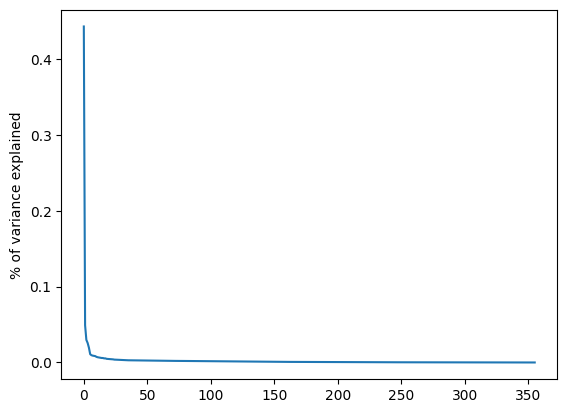

In [17]:
# PCA
from sklearn import decomposition
pca = decomposition.PCA(n_components=356) #number of all columns after cleaning
pca.fit(azdias_scaled)
#pca.fit(azdias_normalized)
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('% of variance explained')

In [18]:
pca.explained_variance_ratio_

array([4.42937702e-01, 4.90550128e-02, 2.97718610e-02, 2.57427901e-02,
       1.95883809e-02, 1.09379519e-02, 9.58745771e-03, 9.02237921e-03,
       8.71721242e-03, 8.36624450e-03, 7.36187457e-03, 6.86159139e-03,
       6.52099717e-03, 6.30518654e-03, 5.92908886e-03, 5.88458512e-03,
       5.40041646e-03, 5.38698106e-03, 4.78783203e-03, 4.67926777e-03,
       4.64725780e-03, 4.32787709e-03, 4.23646314e-03, 4.11832733e-03,
       3.78901891e-03, 3.69566969e-03, 3.61299676e-03, 3.53385948e-03,
       3.44133724e-03, 3.33150828e-03, 3.29113433e-03, 3.15626524e-03,
       3.04689882e-03, 3.02777837e-03, 2.93646567e-03, 2.89817533e-03,
       2.87234309e-03, 2.84397712e-03, 2.80839584e-03, 2.80490490e-03,
       2.76048844e-03, 2.75278754e-03, 2.72662495e-03, 2.71786403e-03,
       2.68213933e-03, 2.65033640e-03, 2.62573085e-03, 2.61848974e-03,
       2.59110794e-03, 2.57229106e-03, 2.56039853e-03, 2.53549728e-03,
       2.49920486e-03, 2.49036750e-03, 2.45938919e-03, 2.44250620e-03,
      

In [19]:
#from the above figure, and using the elbow method, the suitable n_components around 12
pca = decomposition.PCA(n_components= 12) 
pca.fit(azdias_scaled)
azdias_pca = pd.DataFrame(pca.transform(azdias_scaled))

```python
from sklearn import cluster
minPoints = 1000
epsilon = 1
dbscan = cluster.DBSCAN(eps=epsilon, min_samples=minPoints)
clustering_labels = dbscan.fit_predict(azdias_pca)
```

```python
noise = list(clustering_labels).count(-1)
noise #891203
```

Since, all points are considered noise, I'll try another epsilon and minPoints

In [21]:
azdias_pca.iloc[:, 0:12]

,0,1,2,3,4,5,6,7,8,9,10,11
0,-10.499283,-2.371358,-0.215653,1.248360,-0.168814,0.148468,-0.561606,-0.626208,-0.093091,1.417004,-1.106531,1.304513
1,-10.506717,-2.232284,1.031635,0.897302,-1.915724,-0.229423,-1.201727,-0.553476,-0.802173,1.153700,-1.194413,1.363472
2,-10.396139,-0.765367,-0.560176,-0.032397,-0.252085,-2.182009,0.453167,1.021593,-1.330979,-0.532511,0.427930,-0.554747
3,-10.367405,0.403549,-2.388359,0.210330,0.429347,0.170635,0.381213,0.654856,-0.263797,0.326225,-1.177149,-0.189425
4,-10.107229,3.460117,4.209774,-0.511162,0.791422,0.570956,2.250512,0.566986,2.671612,-0.802753,-0.310437,2.482498
...,...,...,...,...,...,...,...,...,...,...,...,...
891198,-9.439692,1.818834,1.197411,-1.700453,-0.998446,-0.942562,0.393546,-2.995959,-0.467515,0.532930,-0.693489,-1.662158
891199,-8.986961,-3.789412,1.303013,-1.248680,0.321500,0.050210,-0.278993,1.187369,-0.097618,2.014624,-0.953268,0.428500
891200,-8.775396,1.135882,0.467268,-0.536083,-2.065385,-0.099629,0.721241,0.492124,-0.816424,1.216900,-1.210743,-1.438073
891201,-8.947196,-2.432511,1.624927,-3.372090,-0.556992,0.923383,-2.885781,0.457484,0.241571,-0.527907,-0.296486,0.627297


```python
from sklearn import cluster
minPoints = 5
epsilon = 1
dbscan = cluster.DBSCAN(eps=epsilon, min_samples=minPoints)
clustering_labels_1 = dbscan.fit_predict(azdias_pca.iloc[:, 0:12])
```

```python
list(clustering_labels_1).count(-1)
#844450
```

``` python
print(set(clustering_labels_1))
azdias_pca['cluster_dbscan']=clustering_labels_1
azdias_pca['cluster_dbscan'].hist()
azdias_pca.drop(columns=['cluster_dbsan', 'cluster_dbscan'], inplace=True)
```

<Axes: >

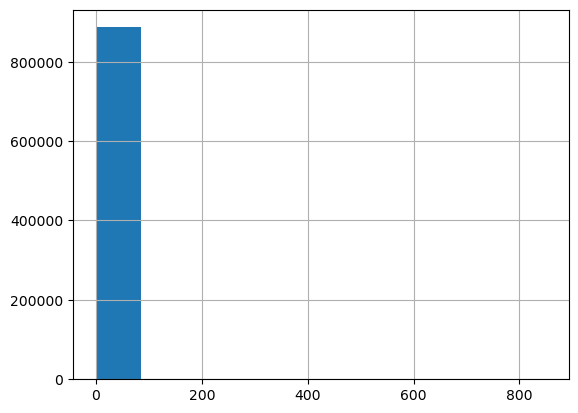

In [36]:
azdias_pca['cluster_dbscan']=clustering_labels_1
azdias_pca['cluster_dbscan'].hist()

Since, most of points are considered noise, I'll try another algorithm

In [22]:
with open('azdias_pca.pkl', 'wb') as f:
    pickle.dump(azdias_pca, f)

In [23]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(azdias_pca)

cluster_labels = kmeans.labels_




C:\Users\dell\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
set(cluster_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [25]:
azdias_pca['cluster']=cluster_labels

In [26]:
azdias_pca

,0,1,2,3,4,5,6,7,8,9,10,11,cluster
0,-10.499283,-2.371358,-0.215653,1.248360,-0.168814,0.148468,-0.561606,-0.626208,-0.093091,1.417004,-1.106531,1.304513,7
1,-10.506717,-2.232284,1.031635,0.897302,-1.915724,-0.229423,-1.201727,-0.553476,-0.802173,1.153700,-1.194413,1.363472,7
2,-10.396139,-0.765367,-0.560176,-0.032397,-0.252085,-2.182009,0.453167,1.021593,-1.330979,-0.532511,0.427930,-0.554747,7
3,-10.367405,0.403549,-2.388359,0.210330,0.429347,0.170635,0.381213,0.654856,-0.263797,0.326225,-1.177149,-0.189425,7
4,-10.107229,3.460117,4.209774,-0.511162,0.791422,0.570956,2.250512,0.566986,2.671612,-0.802753,-0.310437,2.482498,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
891198,-9.439692,1.818834,1.197411,-1.700453,-0.998446,-0.942562,0.393546,-2.995959,-0.467515,0.532930,-0.693489,-1.662158,7
891199,-8.986961,-3.789412,1.303013,-1.248680,0.321500,0.050210,-0.278993,1.187369,-0.097618,2.014624,-0.953268,0.428500,7
891200,-8.775396,1.135882,0.467268,-0.536083,-2.065385,-0.099629,0.721241,0.492124,-0.816424,1.216900,-1.210743,-1.438073,7
891201,-8.947196,-2.432511,1.624927,-3.372090,-0.556992,0.923383,-2.885781,0.457484,0.241571,-0.527907,-0.296486,0.627297,7


<Axes: >

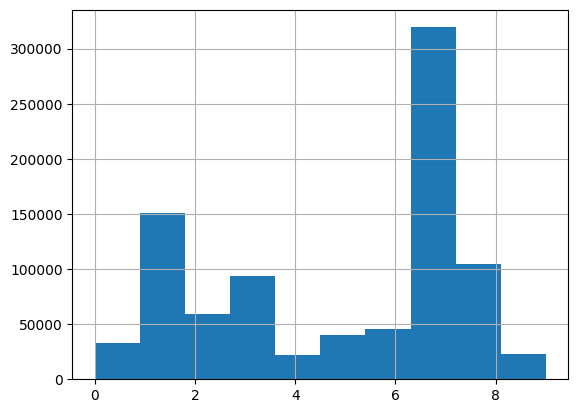

In [27]:
azdias_pca['cluster'].hist()

In [28]:
with open('azdias_pca_cluster.pkl', 'wb') as f:
    pickle.dump(azdias_pca, f)

# Compare customers to azdias

In [6]:
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\dell\AppData\Local\Temp\ipykernel_15620\3968071252.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')


In [7]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [8]:
clean_unsupervised(customers)

C:\Users\dell\AppData\Local\Temp\ipykernel_15620\1491132011.py:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  unknowns.set_axis(unknowns.iloc[0,:], axis='columns', inplace=True)#inplace worked on another environment #rename column names


Column 'BIP_FLAG' not found in DataFrame.
Column 'CAMEO_DEUINTL_2015' not found in DataFrame.
Column 'D19_KK_KUNDENTYP' not found in DataFrame.
Column 'GEOSCORE_KLS7' not found in DataFrame.
Column 'HAUSHALTSSTRUKTUR' not found in DataFrame.
Column 'KBA13_CCM_1400_2500' not found in DataFrame.
Column 'SOHO_FLAG' not found in DataFrame.
Column 'WACHSTUMSGEBIET_NB' not found in DataFrame.
Index(['2D', '6B', '4C', '3D', '4A', '3C', '1D', '2C', '5D', '8A', '1A', '7A',
       '8B', '2A', '2B', '7B', '1E', '6E', '6C', '8C', '8D', '1C', '4D', '4B',
       '5A', '9D', '3A', '3B', '5B', '5C', '9E', '4E', '6D', '7C', '6F', '1B',
       '5F', '7E', '9A', '9C', '9B', '5E', '7D', '6A', 'XX'],
      dtype='object')
45
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, nan]
45


In [9]:
customers.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,9.0,11.0,NaN,NaN,NaN,0.0,3.0,NaN,0.0,...,3.0,NaN,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1.0,8.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [10]:
customers['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [11]:
customers['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [12]:
customers['ONLINE_PURCHASE'].value_counts()

0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

In [22]:
with open('azdias_pca_cluster.pkl', 'rb') as f:
    azdias_pca = pickle.load(f)

In [21]:
with open('azdias_cleaned_numerical.pkl', 'rb') as f:
    azdias_cleaned = pickle.load(f)

In [23]:
azdias_pca

,0,1,2,3,4,5,6,7,8,9,10,11,cluster
0,-10.499283,-2.371358,-0.215653,1.248360,-0.168814,0.148468,-0.561606,-0.626208,-0.093091,1.417004,-1.106531,1.304513,7
1,-10.506717,-2.232284,1.031635,0.897302,-1.915724,-0.229423,-1.201727,-0.553476,-0.802173,1.153700,-1.194413,1.363472,7
2,-10.396139,-0.765367,-0.560176,-0.032397,-0.252085,-2.182009,0.453167,1.021593,-1.330979,-0.532511,0.427930,-0.554747,7
3,-10.367405,0.403549,-2.388359,0.210330,0.429347,0.170635,0.381213,0.654856,-0.263797,0.326225,-1.177149,-0.189425,7
4,-10.107229,3.460117,4.209774,-0.511162,0.791422,0.570956,2.250512,0.566986,2.671612,-0.802753,-0.310437,2.482498,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
891198,-9.439692,1.818834,1.197411,-1.700453,-0.998446,-0.942562,0.393546,-2.995959,-0.467515,0.532930,-0.693489,-1.662158,7
891199,-8.986961,-3.789412,1.303013,-1.248680,0.321500,0.050210,-0.278993,1.187369,-0.097618,2.014624,-0.953268,0.428500,7
891200,-8.775396,1.135882,0.467268,-0.536083,-2.065385,-0.099629,0.721241,0.492124,-0.816424,1.216900,-1.210743,-1.438073,7
891201,-8.947196,-2.432511,1.624927,-3.372090,-0.556992,0.923383,-2.885781,0.457484,0.241571,-0.527907,-0.296486,0.627297,7


In [25]:
azdias_cleaned

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,9,17,21,11,0,0,2,12,0,...,4,8,11,10,3,9,4,3,1,2
1,910220,9,17,21,11,0,0,2,12,0,...,4,8,11,10,3,9,4,5,2,1
2,910225,9,17,17,10,0,0,1,7,0,...,2,9,9,6,3,9,2,5,2,3
3,910226,1,13,13,1,0,0,0,2,0,...,0,7,10,11,3,9,7,3,2,4
4,910241,1,20,14,3,0,0,4,3,0,...,2,3,5,4,2,9,3,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,5,17,17,15,0,0,1,11,0,...,2,4,7,8,3,4,3,4,2,3
891217,825771,9,16,16,11,0,0,1,11,0,...,4,6,9,6,6,9,5,6,1,2
891218,825772,1,17,17,3,0,0,0,3,0,...,2,7,10,8,6,5,7,4,2,2
891219,825776,9,17,20,7,0,1,1,5,0,...,4,9,8,5,1,9,5,5,1,1


Last index is 891220 not 891202	because of the dropped rows in the cleaning process

In [26]:
azdias_cleaned = azdias_cleaned.reset_index(drop=True)

In [27]:
azdias_cleaned

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,9,17,21,11,0,0,2,12,0,...,4,8,11,10,3,9,4,3,1,2
1,910220,9,17,21,11,0,0,2,12,0,...,4,8,11,10,3,9,4,5,2,1
2,910225,9,17,17,10,0,0,1,7,0,...,2,9,9,6,3,9,2,5,2,3
3,910226,1,13,13,1,0,0,0,2,0,...,0,7,10,11,3,9,7,3,2,4
4,910241,1,20,14,3,0,0,4,3,0,...,2,3,5,4,2,9,3,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891198,825761,5,17,17,15,0,0,1,11,0,...,2,4,7,8,3,4,3,4,2,3
891199,825771,9,16,16,11,0,0,1,11,0,...,4,6,9,6,6,9,5,6,1,2
891200,825772,1,17,17,3,0,0,0,3,0,...,2,7,10,8,6,5,7,4,2,2
891201,825776,9,17,20,7,0,1,1,5,0,...,4,9,8,5,1,9,5,5,1,1


In [28]:
azdias_cleaned['cluster'] = azdias_pca['cluster']
azdias_cleaned

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster
0,910215,9,17,21,11,0,0,2,12,0,...,8,11,10,3,9,4,3,1,2,7
1,910220,9,17,21,11,0,0,2,12,0,...,8,11,10,3,9,4,5,2,1,7
2,910225,9,17,17,10,0,0,1,7,0,...,9,9,6,3,9,2,5,2,3,7
3,910226,1,13,13,1,0,0,0,2,0,...,7,10,11,3,9,7,3,2,4,7
4,910241,1,20,14,3,0,0,4,3,0,...,3,5,4,2,9,3,4,1,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891198,825761,5,17,17,15,0,0,1,11,0,...,4,7,8,3,4,3,4,2,3,7
891199,825771,9,16,16,11,0,0,1,11,0,...,6,9,6,6,9,5,6,1,2,7
891200,825772,1,17,17,3,0,0,0,3,0,...,7,10,8,6,5,7,4,2,2,7
891201,825776,9,17,20,7,0,1,1,5,0,...,9,8,5,1,9,5,5,1,1,7


In [40]:
azdias_cleaned

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster
0,910215,9,17,21,11,0,0,2,12,0,...,8,11,10,3,9,4,3,1,2,7
1,910220,9,17,21,11,0,0,2,12,0,...,8,11,10,3,9,4,5,2,1,7
2,910225,9,17,17,10,0,0,1,7,0,...,9,9,6,3,9,2,5,2,3,7
3,910226,1,13,13,1,0,0,0,2,0,...,7,10,11,3,9,7,3,2,4,7
4,910241,1,20,14,3,0,0,4,3,0,...,3,5,4,2,9,3,4,1,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891198,825761,5,17,17,15,0,0,1,11,0,...,4,7,8,3,4,3,4,2,3,7
891199,825771,9,16,16,11,0,0,1,11,0,...,6,9,6,6,9,5,6,1,2,7
891200,825772,1,17,17,3,0,0,0,3,0,...,7,10,8,6,5,7,4,2,2,7
891201,825776,9,17,20,7,0,1,1,5,0,...,9,8,5,1,9,5,5,1,1,7


In [42]:
len(set(customers['LNR'])&set(azdias_cleaned['LNR']))

0

None of the customers are  in the azdias dataset!!!!

In [44]:
#Try a random LNR from customers, check if it is in azdias_cleaned
azdias_cleaned[azdias_cleaned['LNR']==154561]

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster


In [45]:
#customers['cluster'] = azdias_cleaned['cluster'].where(azdias_cleaned['LNR']==customers['LNR'])
#customers_cluster = customers.merge(azdias_cleaned[['LNR', 'cluster']], on='LNR', how='left')
#customers_cluster
#lnr_cluster_dict = azdias_cleaned.set_index('LNR')['cluster'].to_dict()
#customers['cluster'] = customers['LNR'].map(lnr_cluster_dict)
#customers
# Convert 'LNR' to a common data type (e.g., int) if needed
#azdias_cleaned['LNR'] = azdias_cleaned['LNR'].astype(int)
#customers['LNR'] = customers['LNR'].astype(int)
# Set 'LNR' as the index in both DataFrames
#azdias_cleaned.set_index('LNR', inplace=True)
#customers.set_index('LNR', inplace=True)
# Map 'cluster' values from azdias_cleaned to customers based on matching 'LNR'
#customers['cluster'] = azdias_cleaned['cluster']
# Reset the index if desired
#customers.reset_index(inplace=True)
#customers

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [47]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\dell\AppData\Local\Temp\ipykernel_15620\3492614913.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [48]:
mailout_train.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,42962.000000,42962.000000,35993.000000,35993.000000,1988.000000,756.000000,174.000000,41.000000,34807.000000,35185.000000,...,35695.000000,35695.000000,35695.000000,33284.000000,35993.000000,35185.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,42803.120129,0.542922,1.525241,10.285556,12.606137,13.783069,14.655172,14.195122,9.855058,6.706096,...,4.318644,4.505953,3.116963,4.488403,8.729947,4.059685,2.804199,0.012383,1.595084,3.213910
std,24778.339984,1.412924,1.741500,6.082610,3.924976,3.065817,2.615329,3.034959,4.373539,15.151790,...,3.165199,3.289502,2.534331,1.889573,1.010545,2.046697,1.121585,0.110589,0.490881,1.067475
min,1.000000,-1.000000,1.000000,0.000000,2.000000,5.000000,6.000000,6.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,21284.250000,-1.000000,1.000000,8.000000,9.000000,12.000000,13.000000,13.000000,8.000000,1.000000,...,1.000000,2.000000,1.000000,3.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
50%,42710.000000,1.000000,1.000000,10.000000,13.000000,14.000000,15.000000,15.000000,10.000000,2.000000,...,3.000000,4.000000,2.000000,6.000000,9.000000,3.000000,3.000000,0.000000,2.000000,4.000000
75%,64340.500000,2.000000,1.000000,15.000000,16.000000,16.000000,17.000000,17.000000,13.000000,7.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,7.000000,3.000000,0.000000,2.000000,4.000000
max,85795.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,438.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [49]:
clean_supervised(mailout_train.drop(columns='RESPONSE'))

C:\Users\dell\AppData\Local\Temp\ipykernel_15620\1491132011.py:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  unknowns.set_axis(unknowns.iloc[0,:], axis='columns', inplace=True)#inplace worked on another environment #rename column names


Column 'BIP_FLAG' not found in DataFrame.
Column 'CAMEO_DEUINTL_2015' not found in DataFrame.
Column 'D19_KK_KUNDENTYP' not found in DataFrame.
Column 'GEOSCORE_KLS7' not found in DataFrame.
Column 'HAUSHALTSSTRUKTUR' not found in DataFrame.
Column 'KBA13_CCM_1400_2500' not found in DataFrame.
Column 'SOHO_FLAG' not found in DataFrame.
Column 'WACHSTUMSGEBIET_NB' not found in DataFrame.


In [50]:
mailout_train['RESPONSE'].describe()

count    42962.000000
mean         0.012383
std          0.110589
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: RESPONSE, dtype: float64

In [51]:
'''
roc_auc
AUC (Area Under the Curve) for the ROC curve (Receiver Operating Characteristic curve), relative to the
detection of customers from the mail campaign. A ROC, or receiver operating characteristic, is a graphic
used to plot the true positive rate (TPR, proportion of actual customers that are labeled as so) against
the false positive rate (FPR, proportion of non-customers labeled as customers).
The line plotted on these axes depicts the performance of an algorithm as we sweep across the entire
output value range. We start by accepting no individuals as customers (thus giving a 0.0 TPR and FPR)
then gradually increase the threshold for accepting customers until all individuals are accepted (thus
giving a 1.0 TPR and FPR). The AUC, or area under the curve, summarizes the performance of the model.
If a model does not discriminate between classes at all, its curve should be approximately a diagonal line
from (0, 0) to (1, 1), earning a score of 0.5. A model that identifies most of the customers first, before
starting to make errors, will see its curve start with a steep upward slope towards the upper-left corner
before making a shallow slope towards the upper-right. The maximum score possible is 1.0, if all
customers are perfectly captured by the model first.
''' 
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label='RESPONSE', eval_metric='roc_auc', problem_type='binary', path='supervised_predictor').fit(train_data=mailout_train, time_limit=600, presets='best_quality')

C:\Users\dell\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "supervised_predictor\"
AutoGluon Version:  0.7.0
Python Version:     3.8.5
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19041
Train Data Rows:    42962
Train Data Columns: 366
Label Column: RESPONSE
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1956.64 MB
	Train Data (Original)  Memory Usage: 136.78 MB (7.0% of available memory)
	Inferring d

In [52]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2   0.779534      13.025397  432.788644                0.015623           6.033266            2       True          9
1          CatBoost_BAG_L1   0.772822       0.574480  245.388160                0.574480         245.388160            1       True          7
2        LightGBMXT_BAG_L1   0.770418       0.792371   77.612646                0.792371          77.612646            1       True          3
3          LightGBM_BAG_L1   0.765537       0.796227   69.789671                0.796227          69.789671            1       True          4
4  RandomForestEntr_BAG_L1   0.625567      10.846696   33.964901               10.846696          33.964901            1       True          6
5  RandomForestGini_BAG_L1   0.590953      12.399682   37.123539               1

C:\Users\dell\myenv\lib\site-packages\autogluon\core\utils\plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': 0.49945314618150377,
  'KNeighborsDist_BAG_L1': 0.4982261805822593,
  'LightGBMXT_BAG_L1': 0.770418105716802,
  'LightGBM_BAG_L1': 0.7655371341386698,
  'RandomForestGini_BAG_L1': 0.5909532330118249,
  'RandomForestEntr_BAG_L1': 0.6255665013937152,
  'CatBoost_BAG_L1': 0.7728223088359598,
  'ExtraTreesGini_BAG_L1': 0.5470256184888334,
  'WeightedEnsemble_L2': 0.7795340933053823},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif_BA

Conclusion:   
WeightedEnsemble_L2  is the best fitted model with score 0.778833, prediction time 2.702732  , and fitting time 437.112074

In [53]:
predictor = TabularPredictor.load("supervised_predictor")

In [6]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test.head()

C:\Users\dell\AppData\Local\Temp\ipykernel_22416\255036516.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [14]:
clean_supervised(mailout_test)

C:\Users\dell\AppData\Local\Temp\ipykernel_22416\1491132011.py:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  unknowns.set_axis(unknowns.iloc[0,:], axis='columns', inplace=True)#inplace worked on another environment #rename column names


Column 'BIP_FLAG' not found in DataFrame.
Column 'CAMEO_DEUINTL_2015' not found in DataFrame.
Column 'D19_KK_KUNDENTYP' not found in DataFrame.
Column 'GEOSCORE_KLS7' not found in DataFrame.
Column 'HAUSHALTSSTRUKTUR' not found in DataFrame.
Column 'KBA13_CCM_1400_2500' not found in DataFrame.
Column 'SOHO_FLAG' not found in DataFrame.
Column 'WACHSTUMSGEBIET_NB' not found in DataFrame.


In [222]:
predictions = predictor.predict(mailout_test)

In [223]:
predictions.head()

0    0
1    0
2    0
3    0
4    0
Name: RESPONSE, dtype: object

In [224]:
predictions.describe()

count     42833
unique        1
top           0
freq      42833
Name: RESPONSE, dtype: int64

All predictions are of response zero. These means that they are not predicted to be future customers. And this goes with the fact that the percentage of customers in the train set is no more than 1.2383%

# Submitting to Kaggle as a benchmark:  
When trying to submit I found this message: "This is a limited-participation competition. Only invited users may participate."
And I don't have an invitation